In [1]:
import torch
import torch.nn as nn
from generate_data import *
import matplotlib.pyplot as plt

In [47]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 20
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 16
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 5000
dtype = torch.float


In [23]:

#####################
# Generate data
#####################
data = ARData(num_datapoints,
              num_prev=input_size,
              test_size=test_size, 
              noise_var=noise_var,
              coeffs=fixed_ar_coefficients[input_size])

# make training and test sets in torch
X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])

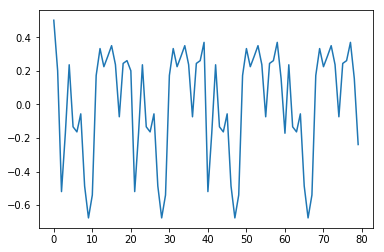

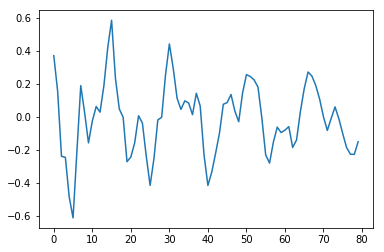

In [33]:
plt.plot(X_train.detach().numpy()[0])
plt.show()
plt.plot(y_train.detach().numpy())
plt.show()

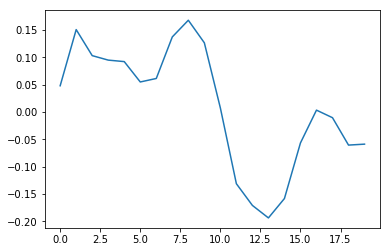

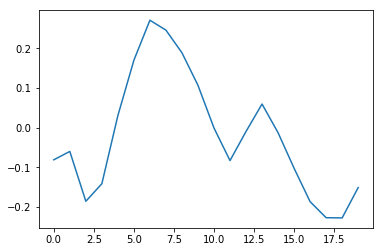

In [32]:
plt.plot(y_test.detach().numpy())
plt.show()
plt.plot(X_test.detach().numpy()[0])
plt.show()

In [48]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


Epoch  0 MSE:  5.503143310546875


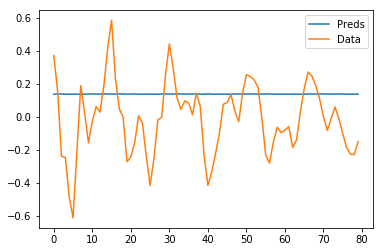

Epoch  100 MSE:  3.6783180236816406


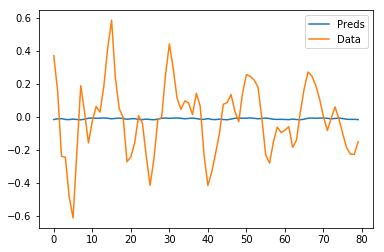

Epoch  200 MSE:  2.4819869995117188


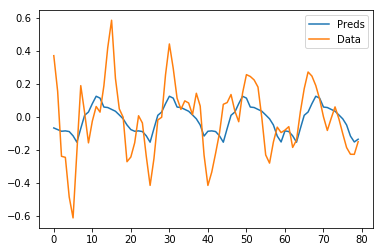

Epoch  300 MSE:  1.8834694623947144


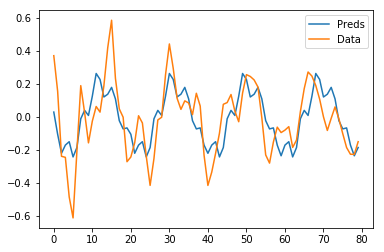

Epoch  400 MSE:  1.7828154563903809


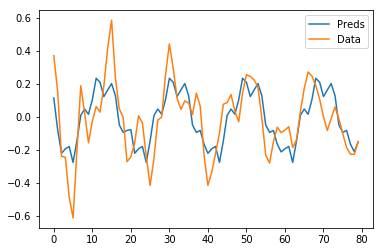

Epoch  500 MSE:  1.7135711908340454


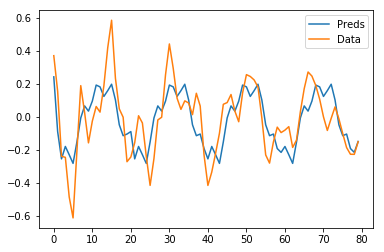

Epoch  600 MSE:  1.6652745008468628


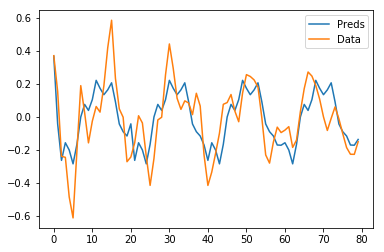

Epoch  700 MSE:  1.661222219467163


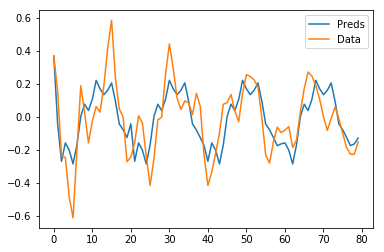

Epoch  800 MSE:  1.6594146490097046


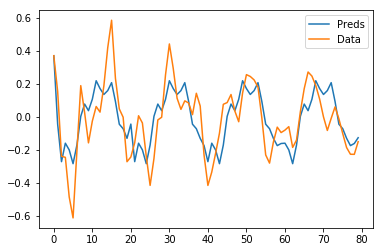

Epoch  900 MSE:  1.658288836479187


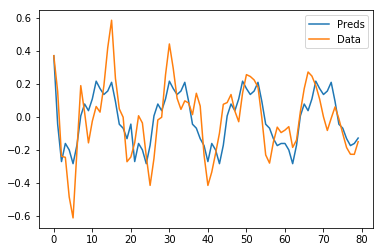

Epoch  1000 MSE:  1.6575504541397095


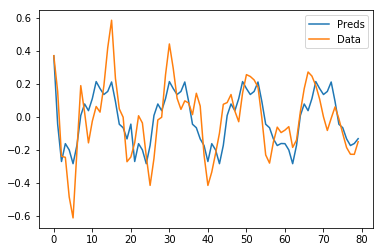

Epoch  1100 MSE:  1.6618354320526123


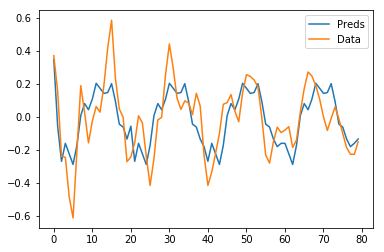

Epoch  1200 MSE:  1.6569383144378662


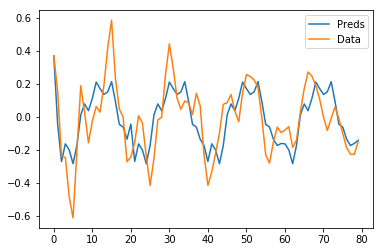

Epoch  1300 MSE:  1.6569907665252686


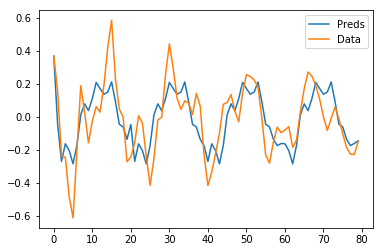

Epoch  1400 MSE:  1.657614827156067


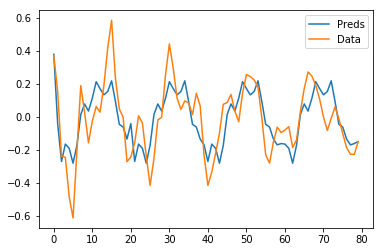

Epoch  1500 MSE:  1.656820297241211


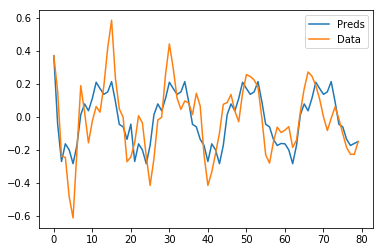

Epoch  1600 MSE:  1.6568217277526855


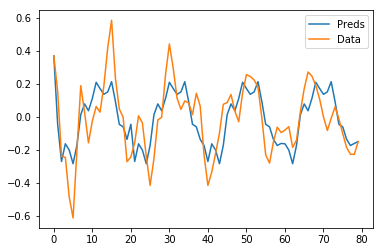

Epoch  1700 MSE:  1.656959891319275


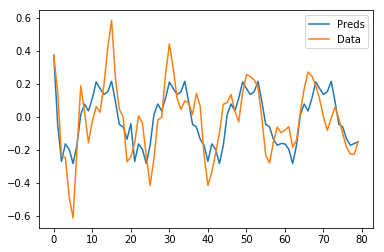

Epoch  1800 MSE:  1.6571335792541504


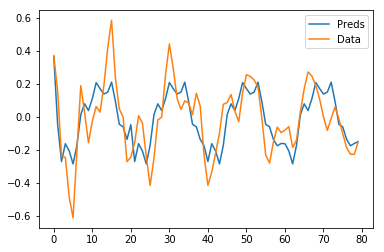

Epoch  1900 MSE:  1.6570076942443848


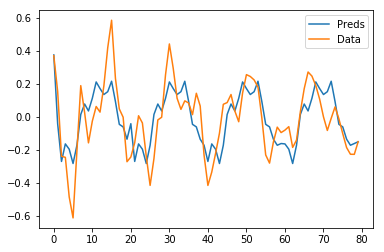

Epoch  2000 MSE:  1.6568318605422974


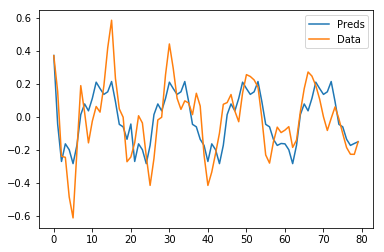

Epoch  2100 MSE:  1.6571166515350342


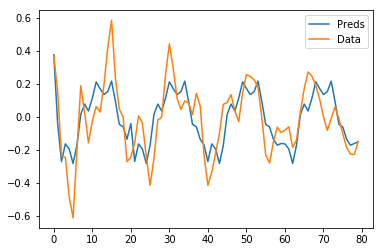

Epoch  2200 MSE:  1.6569029092788696


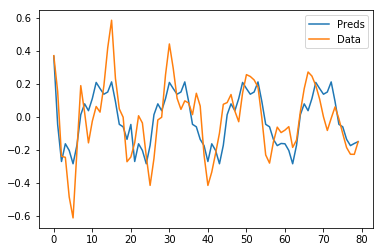

Epoch  2300 MSE:  1.6568371057510376


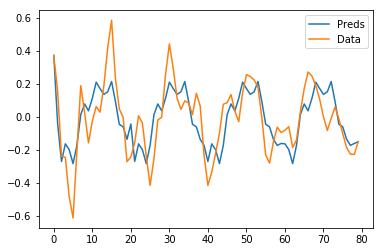

Epoch  2400 MSE:  1.6569277048110962


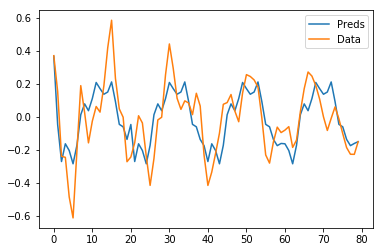

Epoch  2500 MSE:  1.6568183898925781


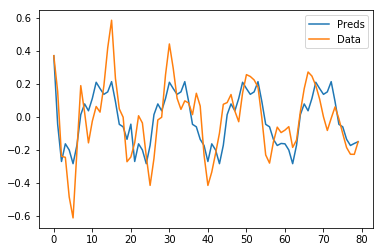

Epoch  2600 MSE:  1.6568180322647095


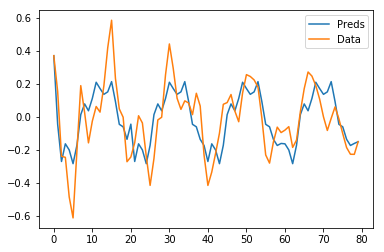

Epoch  2700 MSE:  1.6568223237991333


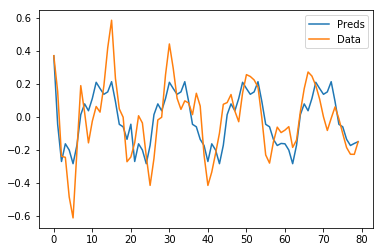

Epoch  2800 MSE:  1.6572688817977905


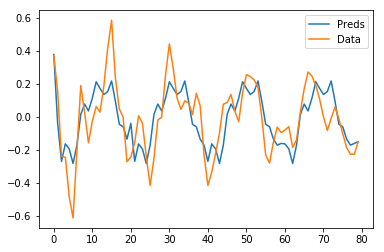

Epoch  2900 MSE:  1.6569254398345947


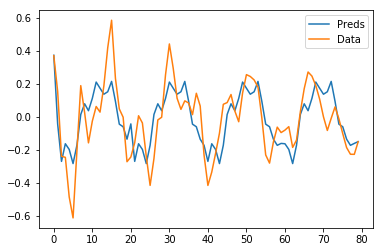

Epoch  3000 MSE:  1.6568267345428467


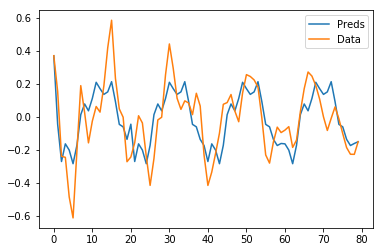

Epoch  3100 MSE:  1.6568527221679688


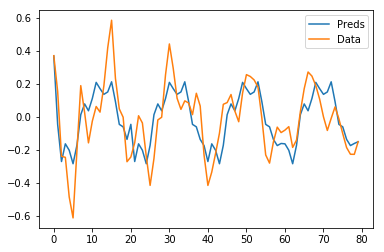

Epoch  3200 MSE:  1.6569010019302368


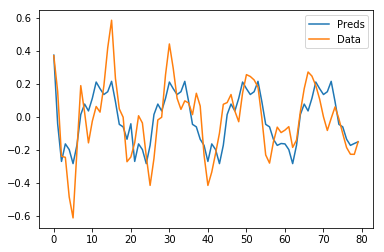

Epoch  3300 MSE:  1.6580437421798706


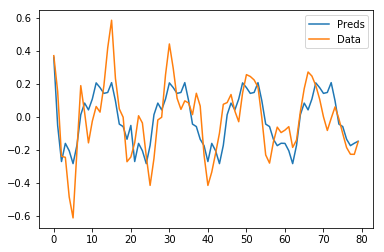

Epoch  3400 MSE:  1.65683114528656


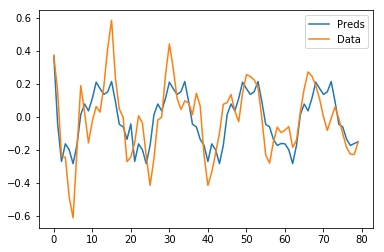

Epoch  3500 MSE:  1.657014012336731


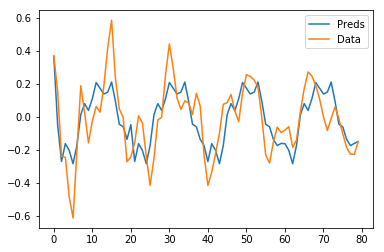

Epoch  3600 MSE:  1.6583200693130493


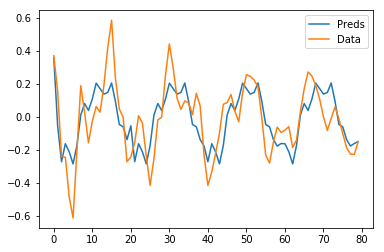

Epoch  3700 MSE:  1.6571491956710815


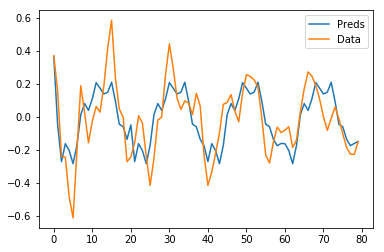

Epoch  3800 MSE:  1.6568495035171509


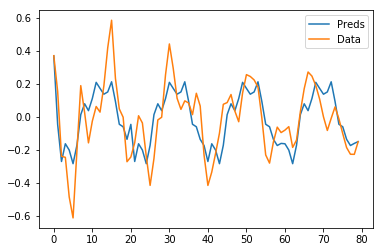

Epoch  3900 MSE:  1.656893253326416


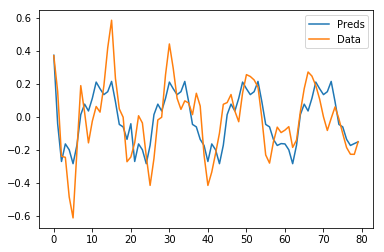

Epoch  4000 MSE:  1.6568251848220825


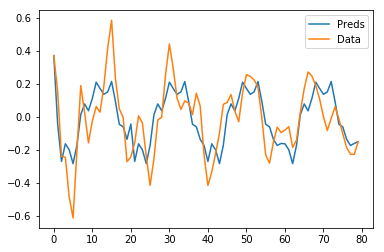

Epoch  4100 MSE:  1.6568247079849243


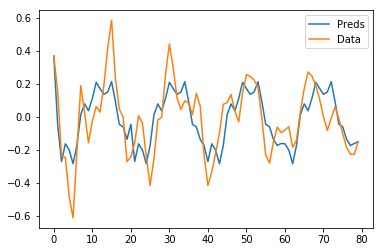

Epoch  4200 MSE:  1.6568182706832886


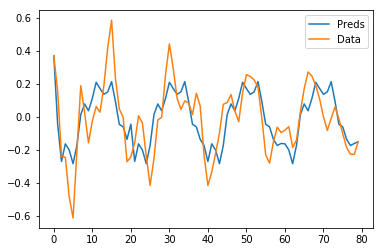

Epoch  4300 MSE:  1.6568219661712646


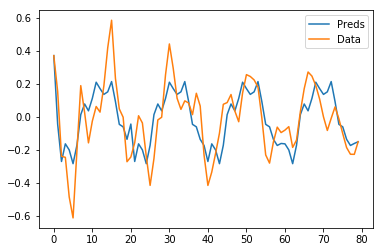

Epoch  4400 MSE:  1.6568264961242676


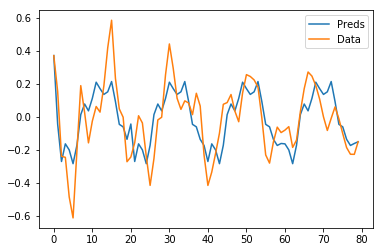

Epoch  4500 MSE:  1.657178282737732


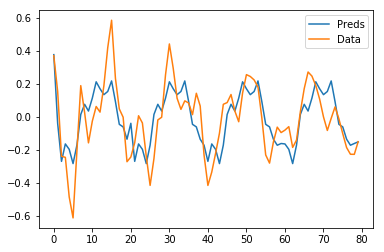

Epoch  4600 MSE:  1.6568715572357178


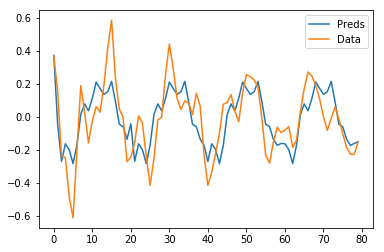

Epoch  4700 MSE:  1.6568267345428467


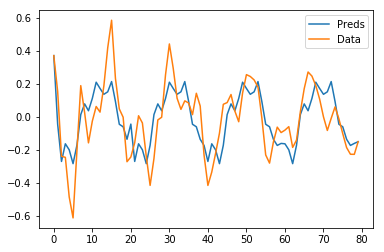

Epoch  4800 MSE:  1.6569513082504272


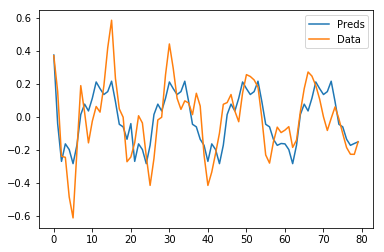

Epoch  4900 MSE:  1.6568433046340942


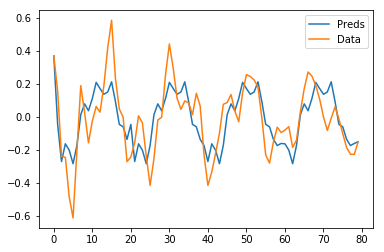

In [49]:

#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred.detach().numpy()[:100], label="Preds")
        plt.plot(y_train.detach().numpy()[:100], label="Data")
        plt.legend()
        plt.show()
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


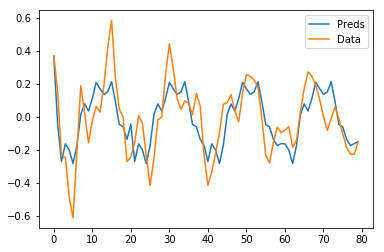

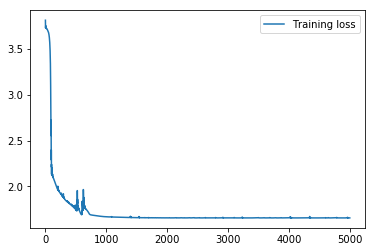

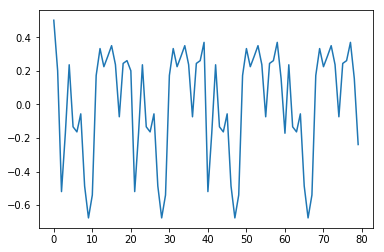

In [46]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")

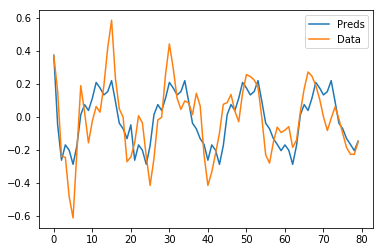

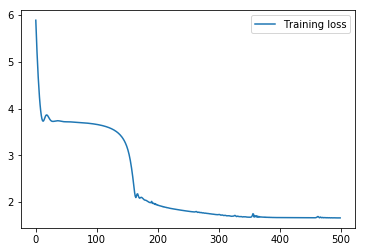

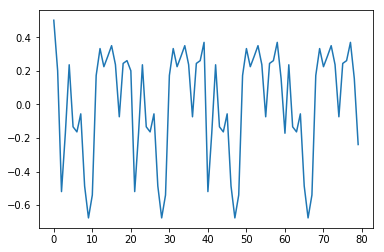

In [30]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")